### [Cookie Cats](https://www.youtube-nocookie.com/embed/GaP5f0jVTWE) is a popular mobile game where players work to clear a board and advance by connecting three matching tiles 

#### The data you will be analyzing in this practice notebook was retrieved from [kaggle](https://www.kaggle.com/yufengsui/mobile-games-ab-testing) but originated as part of a [DataCamp project](https://learn.datacamp.com/projects/184). The variables in the dataset are:
**userid** - a unique identifier for each player    
**version** - whether the player was put in the control group (gate_30) or the experimental group (gate_40)  
**sum_gamerounds** - the number of game rounds played by the player during the first 14 days after installation    
**retention_1** - did the player return to play the game 1 day after installing?  
**retention_7** - did the player return to play the game 7 days after installing?  


#### An A/B Test was designed and run to see if users would be more or less likely to continue playing Cookie Cats 7 days after installing it if they could play to level 40 before encountering a gate instead of hitting their first gate at level 30
 - Gates are used in the game to require a user to wait before continuing play _unless_ they make an in-app purchase. 
 - Two versions of the game were created. One presented the first gate at level 30 (Group A) and the other presented the first gate at level 40 (Group B)
 - Users were randomly assigned to Group A or Group B when they downloaded the app
 - A sample of 40,000 users in each group was determined to be sufficient to measure an effect

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt

from abtesting import power, min_sample_size

%matplotlib inline

#### Get the results of your experiment by loading `cookies_cats.csv`

In [2]:
results = pd.read_csv('../data/cookie_cats.csv')
results.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


You want to run an A/B test to determine if there is a statistically significant difference between the one-day retention rate for players who were presented the gate at level 30 compared to those who were presented the gate at level 40.

First, you need to state your null and alternative hypotheses.

**Null Hypothesis:** There is no difference in one-day retention rates for level 30 players compared to level 40 players.

**Alternative Hypothesis:** The one-day retention rate for level 30 players is different than the one-day retention rate for level 40 players.

You also need to set your significance level. (**Question:** What is a significance level?) For this example, we'll use a significance level of 0.05. 

Historically, there there has been around a 44% 1-day retention rate. You are looking to detect a 1% absolute difference between versions.

**Question:** What sample size do you need for your test to have 80% power? (What is power?) Is the sample that you have sufficient in order to achieve 80% power?

**_reminder: you can enter a function name with a `?` to see info about a function_**

In [3]:
# The needed sample size
min_sample_size(baseline = 0.44, min_effect = 0.01, desired_power = 0.8)

38705

This says that you need 38,705 observations per variant. Now, you can check whether or not you have the needed sample size.

In [4]:
results.version.value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

There are more than enough observations to achieve 80% power.

You can also find the exact power using the `power` function. You should use the smaller number of group observations for the `sample_size` argument.

In [5]:
power(baseline = 0.44, min_effect = 0.01, sample_size = 44700)

0.8532809224120653

Now, you can calculate some point estimates. 

First, use `.groupby` to find the number of players that returned after one day and the total number of players per group.

In [6]:
retention_1 = results.groupby('version')['retention_1'].agg(['sum', 'count'])

In [7]:
retention_1

,sum,count
version,,
gate_30,20034,44700
gate_40,20119,45489


Using these two numbers can generate a point estimate for the retention rate by group.

In [8]:
retention_1['point_estimate'] = retention_1['sum'] / retention_1['count']

In [9]:
retention_1

,sum,count,point_estimate
version,,,
gate_30,20034,44700,0.448188
gate_40,20119,45489,0.442283


Though not strictly needed for running the hypothesis test, you can find the margin of error and confidence interval by following, for example, http://davidmlane.com/hyperstat/B9168.html.

The calculation of margin of error is 

$$\text{margin of error} = z\cdot\sqrt{\frac{p(1-p)}{n}}$$

where $p$ is the point estimate, $n$ is the number of observations, and $z$ depends on the desired level of confidence.

The `norm.ppf` function can be used to find the margin of error, based on the confidence level.

In [10]:
# using a 95% confidence interval
conf_level = 0.95
# Find the z-value
z = norm.ppf(1 - (1 - conf_level) / 2)

retention_1['margin_of_error'] = z * np.sqrt((retention_1['point_estimate'] * (1 - retention_1['point_estimate'])) / retention_1['count'])

retention_1

,sum,count,point_estimate,margin_of_error
version,,,,
gate_30,20034,44700,0.448188,0.004610
gate_40,20119,45489,0.442283,0.004564


The margin of error can be used to find upper and lower bounds for a confidence interval.

In [11]:
retention_1['lower_bound'] = retention_1['point_estimate'] - retention_1['margin_of_error']
retention_1['upper_bound'] = retention_1['point_estimate'] + retention_1['margin_of_error']

In [12]:
def estimate_plot(df):
    df.reset_index().plot.scatter(x = 'version', y = 'point_estimate', s = 75, edgecolor = 'black', zorder = 100)
    for version in df.index:
        plt.plot([version, version], [df.loc[version]['lower_bound'], df.loc[version]['upper_bound']], color = 'black')
    plt.xlim(-0.75, 1.75)
    plt.title('Point Estimates with Margin of Error')
    plt.ylabel('rate')

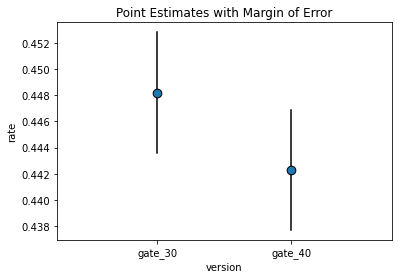

In [13]:
estimate_plot(retention_1)

Based on the plot, there is a difference in the point estimate, but there is quite a bit of overlap in the confidence intervals.

Finally, you can use the `proportions_ztest` function to find the $p$-value for this test. (**Question:** What is a $p$-value?) You need to specify the `count` argument, which in this case is the number retained. You also need to specify the `nobs` argument, which is the number of observations per group.

In [14]:
test_statistic, p_value = proportions_ztest( count = retention_1['sum'], 
                                            nobs = retention_1['count'])

In [15]:
p_value

0.07440965529691913

**Conclusion:** Since the $p$-value is greater than the significance level of 0.05, we do not reject the null hypothesis. There is not enough evidence to conclude that there is a difference in retention rates between the two groups.

## Your turn: 

Determine if the version of Cookie Cats that does not present a gate until level 40 has a statistically significantly different 7-day retention rate than the version that presents a gate at level 30.
**Using a markdown cell**    
1. State the null and alternative hypotheses
2. What is the single variant (difference) between your A and B groups?
3. How is random assignment to each group accomplished?
3. What is the target outcome to measure (your point statistic)?
4. Historically, there has been around a 19% 7-day retention rate. If you want to detect a 1% difference, what sample size is needed for 80% power?
5. Do you have a sufficient sample size?    

**Using code cells**
1. Calculate the following for each group:  
    a. number of observations  
    b. number retained for 7 days  
    c. proportion retained for 7 days  
2. Determine the margin of error at the 95% confidence level.
3. Determine the p-value.

**Be prepared to share your opinion on whether you will accept or reject the null hypothesis.**